In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.7 MB/s eta 0:00:00


In [44]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
raw_data = pd.read_csv("/content/personalvsnonpersonal.csv")

In [6]:
raw_data.head()

,Question,Category
0,What is your full name? ...,Personal: Identity-related
1,Can you provide your date of birth? ...,Personal: Biographical
2,What is your phone number? ...,Personal: Contact information
3,Tell me about your favorite hobbies. ...,Personal: Personal preferences
4,What is your mother's maiden name? ...,Personal: Security-related


In [8]:
raw_data = raw_data.apply(lambda x: x.str.strip())

In [9]:
raw_data.head()

,Question,Category
0,What is your full name?,Personal: Identity-related
1,Can you provide your date of birth?,Personal: Biographical
2,What is your phone number?,Personal: Contact information
3,Tell me about your favorite hobbies.,Personal: Personal preferences
4,What is your mother's maiden name?,Personal: Security-related


In [15]:
raw_data.columns = ["Question", "Category"]

In [17]:
raw_data['Question'].iloc[5]

'Who won the FIFA World Cup in 2018?'

In [18]:
raw_data.sample()

,Question,Category
15,Which is your favorite genre of movies?,Non-Personal: Opinion-based


In [20]:
raw_data.shape

(237, 2)

In [23]:
raw_data.loc[raw_data['Category'].str.contains('Non-Personal')].shape

(109, 2)

In [28]:
raw_data['class'] = raw_data['Category'].str.contains('Non-Personal').astype(int)

In [29]:
raw_data

,Question,Category,Non-personal,class
0,What is your full name?,Personal: Identity-related,False,0
1,Can you provide your date of birth?,Personal: Biographical,False,0
2,What is your phone number?,Personal: Contact information,False,0
3,Tell me about your favorite hobbies.,Personal: Personal preferences,False,0
4,What is your mother's maiden name?,Personal: Security-related,False,0
...,...,...,...,...
232,What is the freezing point of water in Fahrenh...,Non-Personal: General knowledge,True,1
233,"Who is the author of ""Pride and Prejudice""?",Non-Personal: General knowledge,True,1
234,What is the smallest continent on Earth?,Non-Personal: General knowledge,True,1
235,Who discovered the law of gravity?,Non-Personal: General knowledge,True,1


In [34]:
dataset = raw_data[["Question", "class"]].sample(frac=1).reset_index()

In [35]:
dataset.shape

(237, 3)

In [36]:
dataset.head()

,index,Question,class
0,51,What is your occupation?,0
1,220,Who discovered the theory of relativity?,1
2,24,What is your favorite cuisine?,1
3,6,What is your favorite color?,1
4,82,What are your plans for the upcoming holiday s...,1


In [38]:
dataset["class"].value_counts()

0    128
1    109
Name: class, dtype: int64

In [39]:
dataset.isnull().sum()

index       0
Question    0
class       0
dtype: int64

In [40]:
del dataset['index']

In [41]:
train_data, valid_data = train_test_split(dataset, test_size=0.1, stratify=dataset['class'])
train_data, test_data = train_test_split(train_data, test_size=0.2, stratify=train_data['class'])

In [42]:
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [43]:
test_data

,Question,class
0,Tell me about a recent dream you had.,1
1,What is your favorite type of cuisine?,0
2,Tell me about your favorite sports team.,0
3,How was your day spent with friends?,1
4,What is your favorite TV series?,0
5,Who discovered the theory of relativity?,1
6,Who is your favorite musician/band?,1
7,Do you enjoy listening to podcasts?,1
8,Who discovered the theory of relativity?,1
9,What is your highest level of education comple...,0


In [45]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 32
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True)

In [46]:
tokenizer.encode_plus(
            "hate waking sore throat nasty cold yes off",
            None,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [101, 5223, 12447, 14699, 3759, 11808, 3147, 2748, 2125, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [48]:
class TextData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [49]:
train_data = train_data.reset_index(drop=True)

train_df = pd.DataFrame()
train_df['text'] = train_data['Question']
train_df['labels'] = train_data['class']

valid_df = pd.DataFrame()
valid_df['text'] = valid_data['Question']
valid_df['labels'] = valid_data['class']

test_df = pd.DataFrame()
test_df['text'] = test_data['Question']
test_df['labels'] = test_data['class']

print("FULL Dataset: {}".format(dataset.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

training_set = TextData(train_df, tokenizer, MAX_LEN)
valid_set = TextData(valid_df, tokenizer, MAX_LEN)
testing_set = TextData(test_df, tokenizer, MAX_LEN)

FULL Dataset: (237, 2)
TRAIN Dataset: (170, 2)
TEST Dataset: (43, 2)


In [50]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(valid_set, **test_params)
testing_loader = DataLoader(testing_set, **test_params)

In [58]:
class DebertaClass(torch.nn.Module):
    def __init__(self):
        super(DebertaClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [59]:
model = DebertaClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DebertaClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_fe

In [60]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

In [61]:
train_losses = [] 
train_accuracies = [] 
val_losses = [] 
val_accuracies = []

def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [62]:
def evaluate(model, testing_loader):
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, dim=1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    accuracy = (val_correct * 100) / val_total
    average_loss = val_loss / len(validation_loader)

    return average_loss, accuracy

In [63]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    accuracy_steps = []
    loss_steps = []
    validation_step = []
    valaccuracy_step = []
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%1000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 1000 steps: {loss_step}")
            print(f"Training Accuracy per 1000 steps: {accu_step}")
            
            accuracy_steps.append(accu_step)
            loss_steps.append(loss_step)
            
            # Evaluation using the validation loader
            validation_loss, validation_accuracy = evaluate(model, validation_loader)
            print(f"Validation Loss: {validation_loss}")
            print(f"Validation Accuracy: {validation_accuracy}")
            valaccuracy_step.append(validation_accuracy)
            validation_step.append(validation_loss)

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
#     print(f"Training Loss Epoch: {epoch_loss}")
#     print(f"Training Accuracy Epoch: {epoch_accu}")

    return epoch_loss, epoch_accu,loss_steps, accuracy_steps, valaccuracy_step, validation_step

In [65]:
EPOCHS = 5
train_losses = []
train_accuracies = []
train_losses_step = []
train_acc_step = []
val_losses_step = []
val_acc_step = []

for epoch in range(EPOCHS):
    loss, accuracy, loss_step, acc_steps, valacc_step, lossval_step = train(epoch)
    train_losses.append(loss)
    train_accuracies.append(accuracy)
    train_losses_step.extend(loss_step)
    train_acc_step.append(acc_steps)
    val_losses_step.append(lossval_step)
    val_acc_step.append(valacc_step)

0it [00:00, ?it/s]

Training Loss per 1000 steps: 0.6560023427009583
Training Accuracy per 1000 steps: 56.25
Validation Loss: 0.6245630383491516
Validation Accuracy: 70.83333333333333


11it [00:03,  3.26it/s]


The Total Accuracy for Epoch 0: 77.6470588235294


0it [00:00, ?it/s]

Training Loss per 1000 steps: 0.4753471910953522
Training Accuracy per 1000 steps: 81.25
Validation Loss: 0.5519899725914001
Validation Accuracy: 70.83333333333333


11it [00:03,  3.21it/s]


The Total Accuracy for Epoch 1: 92.3529411764706


0it [00:00, ?it/s]

Training Loss per 1000 steps: 0.3934561610221863
Training Accuracy per 1000 steps: 93.75
Validation Loss: 0.46110618114471436
Validation Accuracy: 79.16666666666667


11it [00:03,  3.26it/s]


The Total Accuracy for Epoch 2: 94.70588235294117


0it [00:00, ?it/s]

Training Loss per 1000 steps: 0.25271111726760864
Training Accuracy per 1000 steps: 93.75
Validation Loss: 0.4281366765499115
Validation Accuracy: 79.16666666666667


11it [00:03,  3.24it/s]


The Total Accuracy for Epoch 3: 96.47058823529412


0it [00:00, ?it/s]

Training Loss per 1000 steps: 0.24663349986076355
Training Accuracy per 1000 steps: 87.5
Validation Loss: 0.32785165309906006
Validation Accuracy: 79.16666666666667


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 4: 96.47058823529412


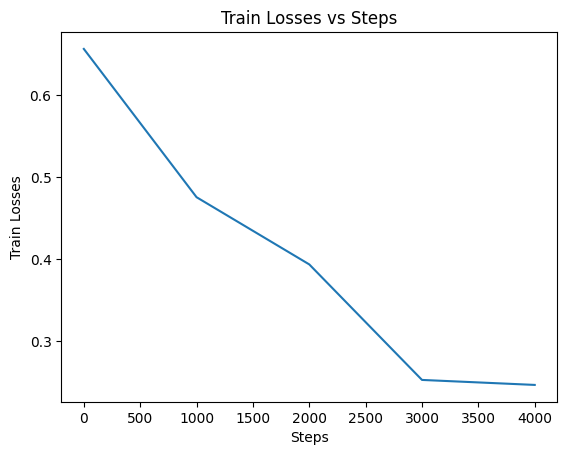

In [66]:
import matplotlib.pyplot as plt

# Creating the steps list
steps = [1000 * i for i in range(len(train_losses_step))]

# Creating the line plot
plt.plot(steps, train_losses_step)

# Adding labels and title
plt.xlabel('Steps')
plt.ylabel('Train Losses')
plt.title('Train Losses vs Steps')

# Displaying the plot
plt.show()


In [68]:
train_acc_step

[[56.25], [81.25], [93.75], [93.75], [87.5]]

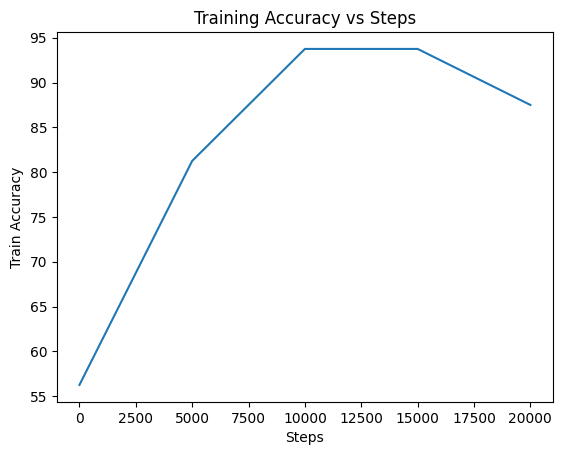

In [71]:
# Creating the steps list
train_acc_steps = [item for sublist in train_acc_step for item in sublist]

steps = [5000 * i for i in range(len(train_acc_steps))]

# Creating the line plot
plt.plot(steps, train_acc_step)

# Adding labels and title
plt.xlabel('Steps')
plt.ylabel('Train Accuracy')
plt.title('Training Accuracy vs Steps')

# Displaying the plot
plt.show()


In [72]:
testing_loss, testing_accuracy = evaluate(model, testing_loader)
print(f"Testing Loss: {testing_loss}")
print(f"Testing Accuracy: {testing_accuracy}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Testing Loss: 0.3468600809574127
Testing Accuracy: 90.69767441860465
